In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from tqdm import tqdm
import random

from matplotlib.dates import AutoDateFormatter, AutoDateLocator, ConciseDateFormatter



In [2]:
datapath = Path(Path().cwd().parents[2]) / 'data'
tpepath = datapath / 'Forecasts' / 'TPE Search results'

In [3]:
waterboards = ['HHNK', 'HDSR', 'Rijnland', 'Waternet']
# wb_exp_name = 'CQRDNN_10_280223_ClusteredUniform'
wb_exp_name = 'CQRDNN_10_280223_NotClustered'
wl_exp_name = 'CQRDNN_WL_IJmuiden'
wbpath = tpepath / wb_exp_name
wlpath = tpepath / wl_exp_name

rijnland_path = tpepath / 'CQRDNN_10_270323_NotClustered' / 'Rijnland'
rijnland_sep_path = tpepath / 'CQRDNN_10_sep_170323_NotClustered' / 'Rijnland'

dam_path = tpepath / 'CQRDNN_DAM'


In [4]:
forecasts = {
    wb: pd.read_csv(wbpath / wb / 'Forecasts' / 'test_fc_sorted.csv', index_col=0, parse_dates=True).astype(float) for wb in waterboards if wb != 'Rijnland'
}
forecasts['WL'] = pd.read_csv(wlpath / 'Forecasts' / 'test_fc_sorted.csv', index_col=0, parse_dates=True).astype(float)
forecasts['Rijnland'] = pd.read_csv(rijnland_path / 'Forecasts' / 'test_fc_sorted.csv', index_col=0, parse_dates=True).astype(float)
forecasts['Rijnland_sep'] = pd.read_csv(rijnland_sep_path / 'Forecasts' / 'test_fc_sorted.csv', index_col=0, parse_dates=True).astype(float)
# forecasts['DAM'] = 


In [5]:
target = {
    wb: pd.read_csv(wbpath / wb / 'Forecasts' / 'y_test.csv', index_col=0, parse_dates=True).astype(float) for wb in waterboards
}
target['WL'] = pd.read_csv(wlpath / 'Forecasts' / 'y_test.csv', index_col=0, parse_dates=True).astype(float)
target['Rijnland'] = pd.read_csv(rijnland_path / 'Forecasts' / 'y_test.csv', index_col=0, parse_dates=True).astype(float)
target['Rijnland_sep'] = pd.read_csv(rijnland_sep_path / 'Forecasts' / 'y_test.csv', index_col=0, parse_dates=True).astype(float)

In [6]:
quantiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
plotdates=None

In [7]:
def operational_plot(plotdate, fc_df, act_df, colname, ax=None, title='', quantiles=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], legend=True):
    where='post'
    if not ax:
        print('No axis provided, creating new figure and axis'	)
        fig, ax = plt.subplots(figsize=(8, 4))
    
    fc = fc_df.loc[plotdate, :]

    act_prev = act_df.loc[plotdate-pd.DateOffset(hours=5), :]
    act = act_df.loc[plotdate, :]
    
    fcindex = pd.date_range(start=plotdate+pd.DateOffset(hours=1), periods=48, freq='H')
    previndex = pd.date_range(start=plotdate-pd.DateOffset(hours=4), periods=6, freq='H')

    for q in quantiles[:int(np.floor(len(quantiles)/2))]:
        ax.fill_between(fcindex, np.array([fc[f'{colname} +{h} q{q}'] for h in range(1,49)]), np.array([fc[f'{colname} +{h} q{1-q}'] for h in range(1,49)]), step=where, alpha=0.5*q, color='red', label=f'{int(np.round(1-2*q, decimals=2)*100)}% PI')
    
    ax.step(fcindex, np.array([fc[f'{colname} +{h} q0.5'] for h in range(1,49)]), color='red', label='Expected value', lw=1, where=where)
    ax.step(previndex, np.array([act_prev[f'{colname} +{h} q0.5'] for h in range(1,7)]), color='tab:blue', label='Actual', where=where, lw=1)
    ax.step(fcindex, np.array([act[f'{colname} +{h} q0.5'] for h in range(1,49)]), color='black', label='Actual', ls='--', lw=1, where=where)
    
    if legend:
        ax.legend(loc='best')

    # ax.set_xlim(plotdate-pd.DateOffset(hours=4), plotdate+pd.DateOffset(hours=48))

In [8]:
def plot_wb(wb, plotdates=None, colname='Aggregated'):
    fc_df = forecasts[wb]
    act_df = target[wb]

    if not plotdates:
        plotdates = sorted([random.choice(fc_df.index) for _ in range(4)])

    fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharey=False)
    
    for i, date in enumerate(plotdates):
        xtick_locator = AutoDateLocator()
        # xtick_formatter = AutoDateFormatter(xtick_locator)
        xtick_formatter = ConciseDateFormatter(xtick_locator)

        ax_ = ax[i//2, i%2]
        
        ax_.xaxis.set_major_locator(xtick_locator)
        ax_.xaxis.set_major_formatter(xtick_formatter)
        ax_.set_xlim(date-pd.DateOffset(hours=4), date+pd.DateOffset(hours=48))
        
        # ax_.set_yticks([-200, 0, 200])
        ax_.axvline(date+pd.DateOffset(hours=1), color='grey', ls=':', lw=1)
        
        operational_plot(date, fc_df=fc_df, act_df=act_df, colname=colname, title=f'Operational plot for {date}', ax=ax_, legend=False)
        ax_.set_ylim(0,None)
        if i%2 == 0:
            ax_.set_ylabel('Discharge [$m^{3}s^{-1}$]]')
        # if i//2 == 1:
            # ax_.set_xlabel('Date')
        
    fig.suptitle(f'{wb} - {colname}')
    fig.tight_layout()

In [9]:
def plot_wl(plotdates=None):
    fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharey=True)
    fc_df = forecasts['WL']
    act_df = target['WL']

    if not plotdates:
        plotdates = sorted([random.choice(fc_df.index) for _ in range(4)])
    
    for i, date in enumerate(plotdates):
        xtick_locator = AutoDateLocator()
        xtick_formatter = ConciseDateFormatter(xtick_locator)

        ax_ = ax[i//2, i%2]
        ax_.xaxis.set_major_locator(xtick_locator)
        ax_.xaxis.set_major_formatter(xtick_formatter)
        ax_.set_xlim(date-pd.DateOffset(hours=4), date+pd.DateOffset(hours=48))
        ax_.set_ylim(-200,200)
        ax_.set_yticks([-200, 0, 200])
        ax_.axvline(date+pd.DateOffset(hours=1), color='grey', ls=':', lw=1)
        
        operational_plot(date, fc_df=fc_df, act_df=act_df, colname='WL', title=f'Operational plot for {date}', ax=ax_, legend=False)
        
        if i%2 == 0:
            ax_.set_ylabel('Water level [cm +NAP]')
        # if i//2 == 1:
            # ax_.set_xlabel('Date')
        
    fig.suptitle('Sea WL at IJmuiden')
    fig.tight_layout()

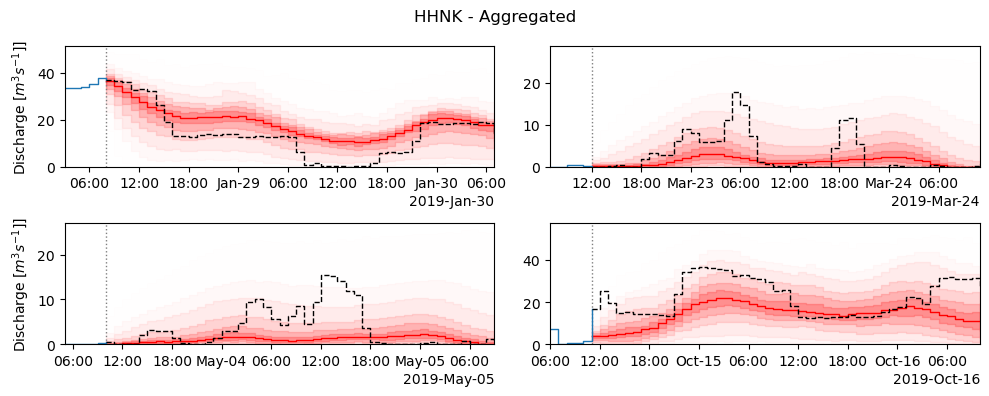

In [34]:
plot_wb('HHNK')

(0.0, 0.13750907558137485)

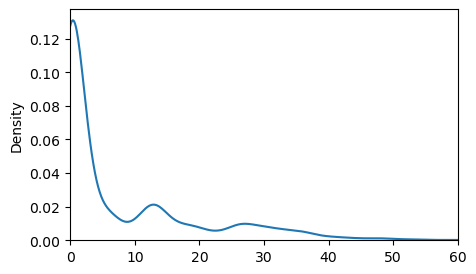

In [87]:
fig, ax = plt.subplots(figsize=(5, 3))
target['HHNK'].loc[:, 'Aggregated +1 q0.5'].apply(lambda x: max(0,x)).round(0).plot.kde(ax=ax)
ax.set_xlim(0, 60)
ax.set_ylim(0, None)

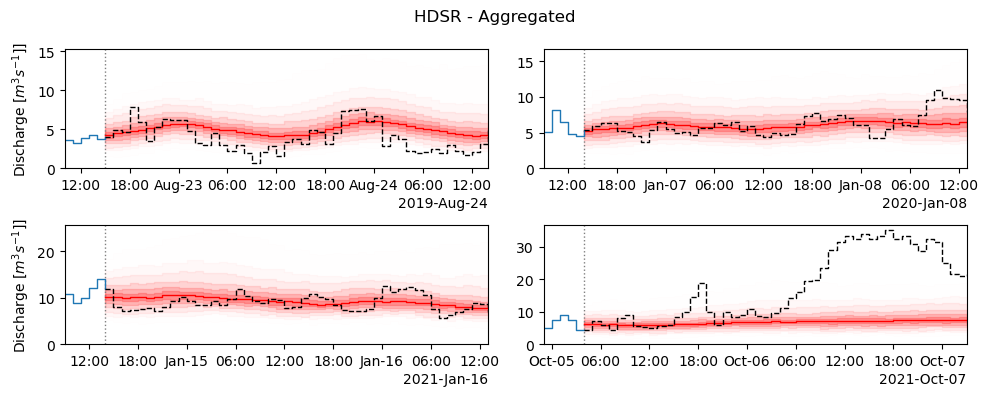

In [37]:
plot_wb('HDSR')

(0.0, 0.11017033780891182)

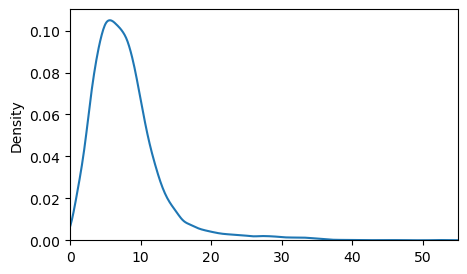

In [89]:
fig, ax = plt.subplots(figsize=(5, 3))
target['HDSR'].loc[:, 'Aggregated +1 q0.5'].apply(lambda x: max(0,x)).round(0).plot.kde(ax=ax)
ax.set_xlim(0, 55)
ax.set_ylim(0, None)

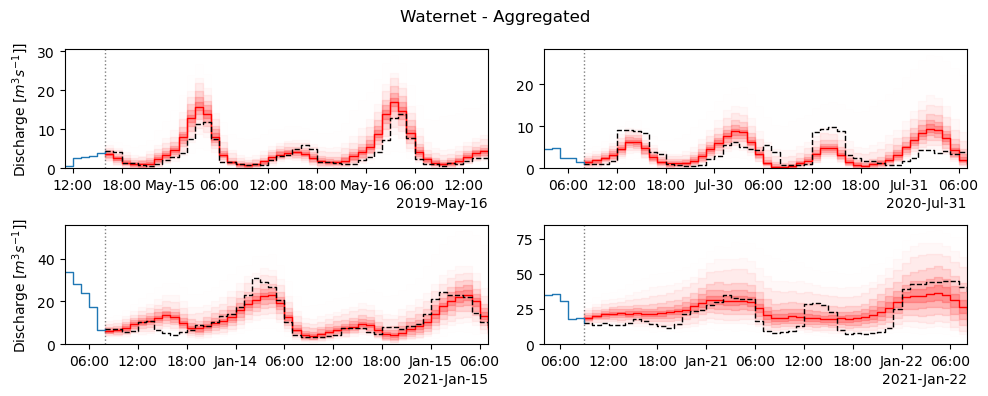

In [12]:
plot_wb('Waternet')

(0.0, 0.09998723111404387)

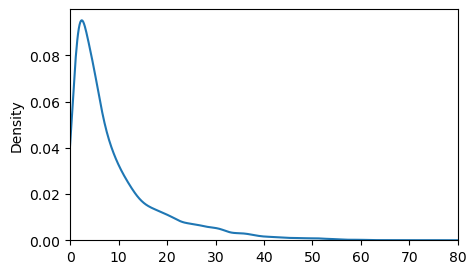

In [91]:
fig, ax = plt.subplots(figsize=(5, 3))
target['Waternet'].loc[:, 'Aggregated +1 q0.5'].apply(lambda x: max(0,x)).round(0).plot.kde(ax=ax)
ax.set_xlim(0, 80)
ax.set_ylim(0, None)

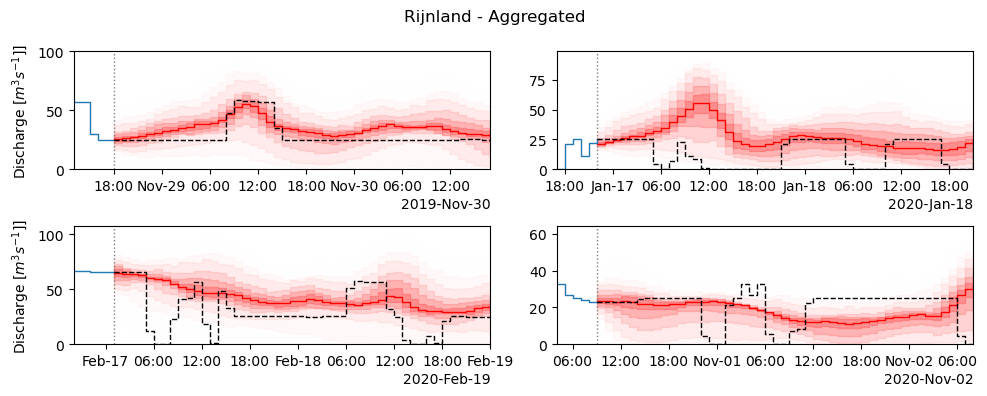

In [55]:
plot_wb('Rijnland')

(0.0, 0.04622238010150948)

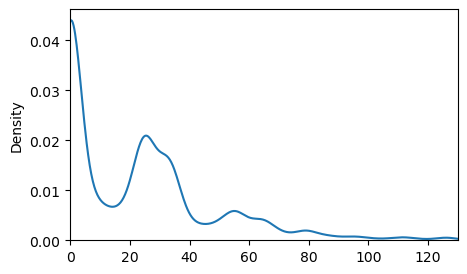

In [93]:
fig, ax = plt.subplots(figsize=(5, 3))
target['Rijnland'].loc[:, 'Aggregated +1 q0.5'].apply(lambda x: max(0,x)).round(0).plot.kde(ax=ax)
ax.set_xlim(0, 130)
ax.set_ylim(0, None)

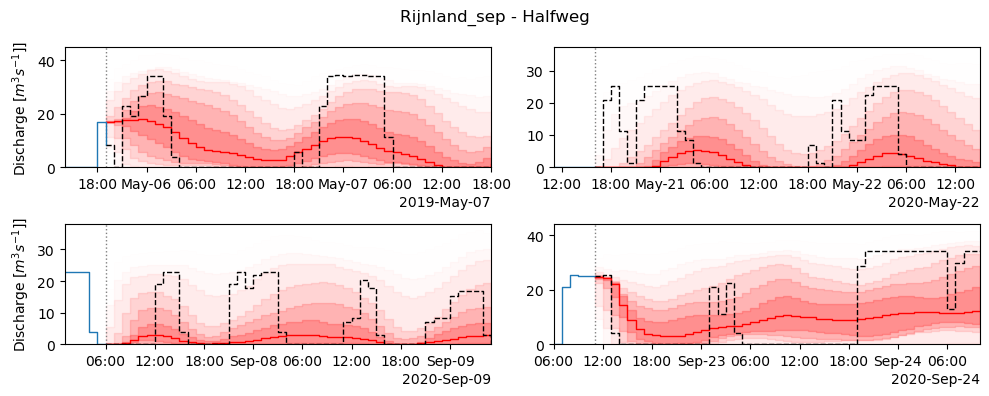

In [52]:
plot_wb('Rijnland_sep', None, 'Halfweg')

(0.0, 0.1039386557196505)

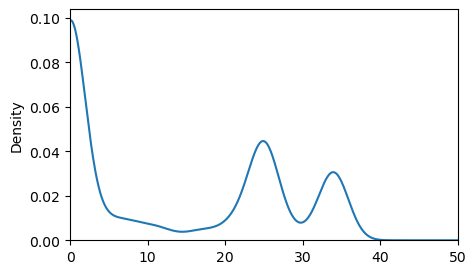

In [101]:
fig, ax = plt.subplots(figsize=(5, 3))
target['Rijnland_sep'].loc[:, 'Halfweg +1 q0.5'].apply(lambda x: max(0,x)).round(0).plot.kde(ax=ax)
ax.set_xlim(0, 50)
ax.set_ylim(0, None)

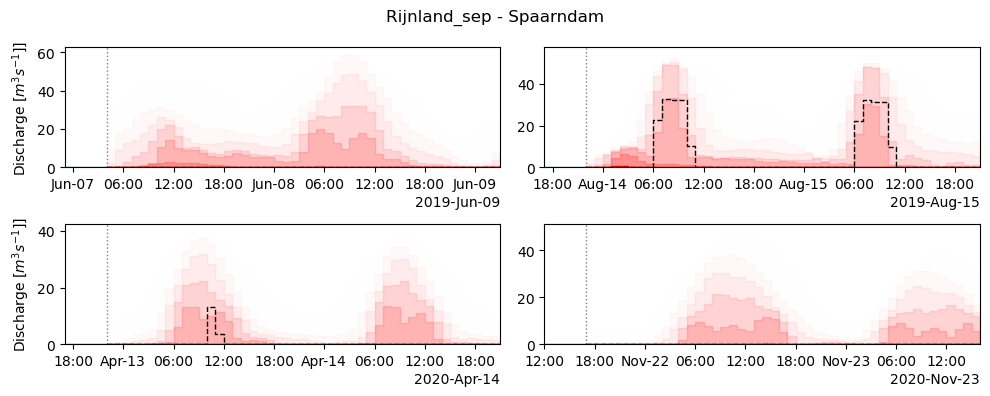

In [15]:
plot_wb('Rijnland_sep', None, 'Spaarndam')

(0.0, 0.24018756938308725)

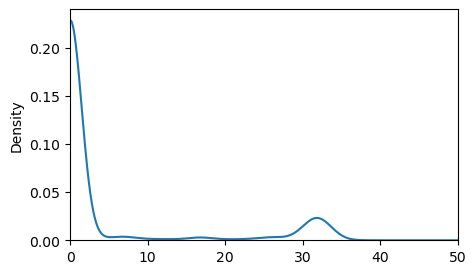

In [97]:
fig, ax = plt.subplots(figsize=(5, 3))
target['Rijnland_sep'].loc[:, 'Spaarndam +1 q0.5'].apply(lambda x: max(0,x)).round(0).plot.kde(ax=ax)
ax.set_xlim(0, 50)
ax.set_ylim(0, None)

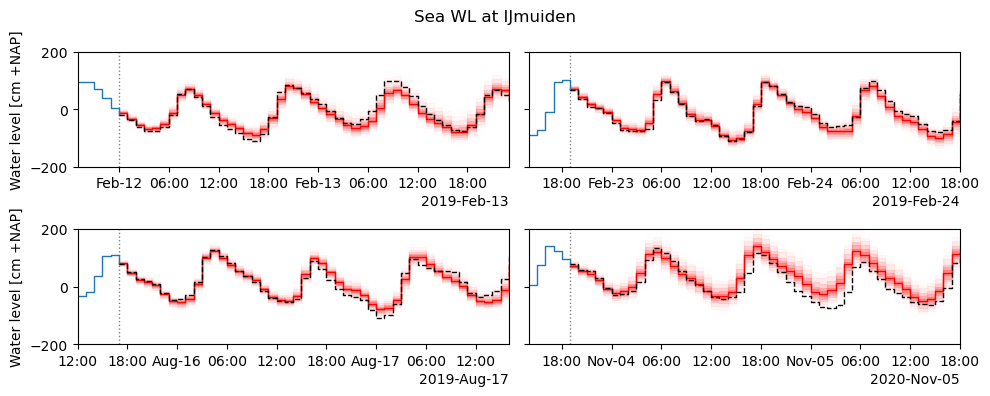

In [56]:
plot_wl()

Text(225, 0.006, 'Gate not possible')

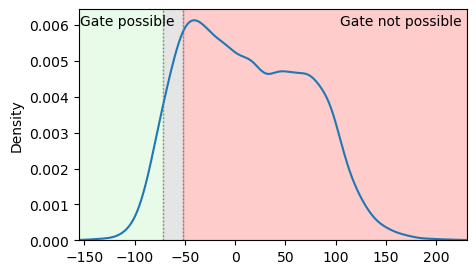

In [99]:
fig, ax = plt.subplots(figsize=(5, 3))
target['WL'].loc[:, 'WL +1 q0.5'].round(0).plot.kde(ax=ax)
ax.set_xlim(-155, 230)
ax.set_ylim(0, None)
ax.axvline(-40-12, color='grey', ls=':', lw=1)
ax.axvline(-60-12, color='grey', ls=':', lw=1)
ax.fill_betweenx([0, 0.05], -40-12, -60-12, color='grey', alpha=0.2)

ax.fill_betweenx([0, 0.05], -155, -60-12, color='lightgreen', alpha=0.2)
ax.fill_betweenx([0, 0.05], -40-12, 230, color='red', alpha=0.2)
ax.text(-60, 0.006, 'Gate possible', ha='right')
ax.text(225, 0.006, 'Gate not possible', ha='right')